In [1]:
import logging, torch, torchvision, torch.nn.functional as F, torchvision.transforms.functional as TF, matplotlib as mpl
import fastcore.all as fc
from matplotlib import pyplot as plt
from functools import partial
from torch import tensor,nn,optim, einsum
from torch.utils.data import DataLoader, default_collate
from torchvision.utils import make_grid
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.learner import *
from miniai.conv import *
from fastcore.all import *
from fastprogress import progress_bar
from einops import rearrange

In [2]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

Load a dataset:

In [3]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

In [5]:
bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([256, 1, 32, 32]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

Define a model:

In [6]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        resnet_block_groups = 8
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, Attention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, Attention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels 
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond = None):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [7]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        store_attr()
        try: self.device = L(self.learn.cbs).filter(f=fc.risinstance(DeviceCB))[0].device
        except: self.device=def_device
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps).to(self.device) # variance schedule, linearly increased with timestep
        self.alpha = 1. - self.beta 
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = torch.sqrt(self.beta)

    def before_batch(self):
        eps = torch.randn(self.learn.batch[0].shape, device=self.learn.batch[0].device)  # noise, x_T
        x0 = self.learn.batch[0] # original images, x_0
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long) # select random timesteps
        alpha_bar_t = self.alpha_bar[t].reshape(-1, 1, 1, 1)
        
        xt =  torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1-alpha_bar_t)*eps #noisify the image
        self.learn.batch = (xt, t, eps) # input to our model is noisy image and timestep, ground truth is the noise 
    
    @torch.no_grad()
    def sample(self, image_size, batch_size=16, channels=3):
        shape = (batch_size, channels, image_size, image_size)
        self.learn.model.to(self.device)
        xt = torch.randn(shape, device=self.device)
        with torch.profiler.profile(
            schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
            on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/ddpm_sampling_wo_no_grad'),
            record_shapes=True,
            profile_memory=True,
            with_stack=True
        ) as prof:
            for t in reversed(range(self.n_steps)):
                t_batch = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
                z = torch.randn(xt.shape, device=xt.device) if t > 0 else torch.zeros(xt.shape, device=xt.device)
                alpha_t = self.alpha[t] # get noise level at current timestep
                alpha_bar_t = self.alpha_bar[t]
                sigma_t = self.sigma[t]
                alpha_bar_t_1 = self.alpha_bar[t-1]  if t > 0 else torch.tensor(1, device=xt.device)
                beta_bar_t = 1 - alpha_bar_t
                beta_bar_t_1 = 1 - alpha_bar_t_1
                x0hat = (xt - torch.sqrt(beta_bar_t) * self.learn.model(xt, t_batch))/torch.sqrt(alpha_bar_t)
                x0hat = torch.clamp(x0hat, -1, 1)
                xt = x0hat * torch.sqrt(alpha_bar_t_1)*(1-alpha_t)/beta_bar_t + xt * torch.sqrt(alpha_t)*beta_bar_t_1/beta_bar_t + sigma_t*z    
                #xt = 1/torch.sqrt(alpha_t) * (xt - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * self.model(xt, t_batch))  + sigma_t*z # predict x_(t-1) in accordance to Algorithm 2 in paper
                prof.step()
        return xt
        
    def predict(self): self.learn.preds = self.learn.model(self.learn.batch[0],self.learn.batch[1])
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[2])
    def backward(self): self.learn.loss.backward()
    def step(self): self.learn.opt.step()
    def zero_grad(self): self.learn.opt.zero_grad()

In [8]:
class DDPMMetricsCB(MetricsCB):
    def __init__(self):
        super().__init__()
    def after_batch(self): self.loss.update(to_cpu(self.learn.loss), weight=len(x))

In [9]:
class ProfilerCB(Callback):
    order = 30
    def __init__(self, **kwargs): self.prof = torch.profiler.profile(**kwargs)
    def before_fit(self): self.prof.start()
    def after_batch(self): self.prof.step()
    def after_fit(self): self.prof.stop()

In [10]:
model = Unet(dim=32, channels=1, dim_mults=(1,2,4,))

In [11]:
profiler_args = {'schedule': torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
                'on_trace_ready': torch.profiler.tensorboard_trace_handler('./log/ddpm_training'),
                'record_shapes': True,
                'profile_memory': True,
                'with_stack': True
                }

In [12]:
cbs = [DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02), DeviceCB(), ProgressCB(),DDPMMetricsCB(), ProfilerCB(**profiler_args)]
learn = Learner(model, dls, nn.MSELoss(), lr=1e-3, cbs=cbs, opt_func=optim.Adam)

In [13]:
learn.fit(5) 

Viewing the predictions on images with increasing noise levels:

In [12]:
batch_size = 16
samples = learn.cbs[0].sample(32, batch_size=batch_size,channels=1)

RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 79.35 GiB total capacity; 49.87 GiB already allocated; 197.69 MiB free; 50.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
samples.shape

torch.Size([16, 1, 32, 32])

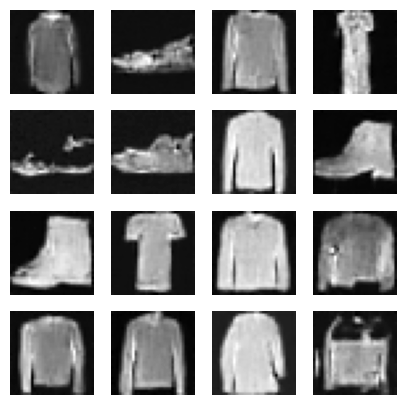

In [ ]:
show_images(-1*samples, figsize=(5,5))